# Exercise 1.2 - Train a Birth-Year Regressor

# Even more text predictions
Text isn't just useful for predicting discrete classes like nationality that you did in your earlier notebook. In this second notebook, you'll develop a _regressor_ instead of a classifier to predict a person's birth year from their Wikipedia biography. Much like nationality, biographies have rich information in their description of places, years, events, or institutions that help contextualize a person's life within a time period. Regression problems are less common than classification in NLP, but can still easily be found, e.g., predicting the number of retweets for a message or predicting box office revenue from a movie's initial reviews.

For this notebook, you'll use a simple regression model, `LinearRegression` but there are many more advanced (and slower) models you could try out using the `sklearn` library. Unlike in classification problems (for the most part), in regression problems, the output classes are related to each other; so, predicting a birth year of 1890 when a person was born in 1892 is wrong but _not that wrong,_ as compared to a prediction like 1442. As a result, we'll evaluate with a different metric instead of F1 here: [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error). 

For this notebook, you'll re-use much of your preprocessing setup that you developed in the first notebook and then sprinkle in regression specific examples. The goal is to help you again build your skills in developing machine learning pipelines for NLP. We've deliberately kept the setup simple, however, as with the first notebook, there are _many_ ways you could extend this approach to improve performance.

Finally, we've included a simple error analysis at the end. As an NLP practitioner, you'll want to get in the habit of looking at your model's predictions. Do they make sense? What kind of bias does my system have? What kind errors does it make and are these systematic? The analysis you do will be simple here, but you can go much further to try to investigate what kinds of errors it's like to make (hint: try looking at some of the highly weighted features!). If you decide to do an error analysis and/or work on improving the model's performance, feel free to discuss in Slack!

In [1]:
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import pandas as pd
from collections import Counter, defaultdict
from sklearn.dummy import DummyRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

It's good practice to manually set your random seed when performing machine learning experiments so that they are reproducible for others. Here, we set our seed to 655 to ensure your models and experiments get the expected results when evaluating your homework.

In [2]:
RANDOM_SEED = 655

# Data Processing

Read in the corpus file, which is in JSON lines format (one line per JSON object). Each line represents cleaned up data a single Wikipedia article for a person. For this exercise, we'll construct a dataframe with the `bio` of the person's article (their biography) and their `birth year`. The birth year is specified as a string in the `birth_date` field of the `infobox` of the page. If someone doesn't have a birth year, you should skip their article; if someone's birthday year isn't specified as an integer, you should skip their article as well.

*Important Note:* In general, it's always a good idea to look at how noisy is your text before deciding on its final form.

In [3]:
birthyear_df = pd.read_csv('assets/birth_year.tsv.gz', sep='\t', compression='gzip')
birthyear_df= birthyear_df[~birthyear_df['bio'].isna()]

Let's check that you have things loaded correctly

### Task 1.2.1: Print the dataset size

In [4]:
print(len(birthyear_df)) # Should be 53456
#hidden tests are within this cell

53456


### Task 1.2.2: Print the number of birth year labels

In [5]:
print(len(set(birthyear_df.birth_year))) # Should be 1552
#hidden tests are within this cell

1552


### Task 1.2.3: Print out the top 20 most common birth years to see what Wikipedia's labels look like

In [6]:
top_20 = Counter(birthyear_df.birth_year).most_common(20)
#hidden tests are within this cell
top_20

[(1954, 477),
 (1948, 477),
 (1952, 474),
 (1953, 457),
 (1957, 453),
 (1947, 453),
 (1956, 449),
 (1955, 447),
 (1950, 441),
 (1959, 439),
 (1951, 437),
 (1960, 436),
 (1958, 436),
 (1962, 422),
 (1961, 411),
 (1944, 410),
 (1946, 410),
 (1963, 410),
 (1964, 409),
 (1949, 408)]

### Life Pro Tip: Always look at your data (always)


### Task 1.2.4: Fix the year labels
We won't fix _everything_ but as a quick improvement, let's bound our years. Remove rows in our dataframe where the birth year is less than -100 or greater than 2020. Put all remaining valid items in the list `clean_birthyear_df`. 

In [7]:
clean_birthyear_df = birthyear_df[~((birthyear_df['birth_year']>2020) | (birthyear_df['birth_year']<-100))]

### Task 1.2.5: Print the number of items in `cleaned_items`

In [8]:
print(len(clean_birthyear_df))
#hidden tests are within this cell

53453


### Task 1.2.6: Split dataset into test, train and dev
We have a large enough dataset that we can effectively split it into train, development, and test sets, using the standard ratio of 80%, 10%, 10% for each, respectively. We'll use `split` from `numpy` to split the data into train, dev, and test separately. We'll call these `train_df`, `dev_df`, and `test_df`.  Note that `split` does not shuffle, so we'll use `DataFrame.sample()` and randomly resample our entire dataset to get a random shuffle before the split.

*Important note*: Remember to set  `random_state` in `split` to our seed so that you end up with the same (random) ordering.

In [9]:
train_df, dev_df, test_df = \
              np.split(clean_birthyear_df.sample(frac=1, random_state=RANDOM_SEED), 
                       [int(.8*len(clean_birthyear_df)), int(.9*len(clean_birthyear_df))])
print(len(train_df), len(dev_df), len(test_df))

42762 5345 5346


### Task 1.2.7: print the `bio` of the first instance of your training set

In [10]:
print(train_df.iloc[0,:]['bio'])
#hidden tests are within this cell

Félix A. Escobar (born 1901, date of death unknown) was an Argentine track and field athlete. Escobar competed in the men's 110 metres , the men's 400 metres, the men's 100 metres, and the men's 4 x 100 metres relay at the 1924 Summer Olympics.


### Task 1.2.8: Print the `bio` of the first instance of the test set

In [11]:
print(test_df.iloc[0,:]['bio'])
#hidden tests are within this cell

Early life and career
Otten was born in Teaneck, New Jersey, where he received his early education. He graduated high school from the Hun School of Princeton in Princeton, New Jersey in 1967 and was named an Alumnus of the Year in 1999. Otten received a B.S. in Business Administration from Ithaca College in 1971, after which he worked for Killington and Sunday River ski resorts. In 1980 he purchased Sunday River, and his company, LBO Resort Enterprises, grew by acquiring Sugarbush, Attitash Bear Peak, and Cranmore
Ski industry career
Otten started his career at Killington Ski Resort in Vermont in 1971. In 1973, at the age of 23, Otten was named ski operation manager of Sunday River in Newry, Maine. In 1980 Otten purchased Sunday River. In 1989, Otten was named Inc. Magazine Entrepreneur of the Year, Turnaround Category.

In 1995 he formed American Skiing Company by acquiring S-K-I, and this expanded his resorts to include Killington, Mount Snow, Haystack, Waterville Valley, and Sugarlo

# Training and testing your classifiers

### Task 1.2.9: Convert your text data to features
The dataset has been prepared and the time has now arrived to actually start doing some predictions! We'll be using a `TfIdfVectorizer` to convert the text into features. There are several important things to note:

1. We have a *lot* of words. There are almost too many to feasibly use unless we're running on a powerful computer. _But_ as we saw above, most words are actually relatively rare. This rarity is quite useful for us because it means we can remove these words as features to our classifier and they shouldn't affect performance too much (after all, the classifier can't learn from features that aren't present).
2. In addition to rare words, there's generally a few very common words. These are often known as _stop words_ like "the". In most settings (but not all!), these features don't add much information so we can safely remove them.

The [TfIdfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class thankfully provides easy ways for us to do both. We'll use `min_df` to ensure that word show up at least 50 times and use `stop_words` to specify their default `english` list. 

Create this `TfIdfVectorizer` and call it vectorizer. Then, call `fit_transform` on the list of biographies in  `train_df` to convert the text into a matrix of features we'll call `X_train`. `X` is the standard name you'll see for talking about the training data that is provided to a classifier. 

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=50, stop_words='english')
X_train = vectorizer.fit_transform(train_df['bio'])

### Task 1.2.10: Sanity Check: print the shape of X_train
Let's ensure that we featurized everything as expected. You should have 8,864 word features in your training data.

In [13]:
print(X_train.shape)
#hidden tests are within this cell

(42762, 8864)


### Task 1.2.11: Get the list of labels
We need to get the final list of labels in a python `list` for sklearn to use. Create this list from `train_df` and let's call it `y_train`. `y` is normally used to refer to the label of the classifier (or value in  a regressor) in machine learning. We use the lower case here to indicate it's a vector, whereas `X` is upper case because it's a matrix.

In [14]:
y_train = list(train_df.birth_year)

### Task 1.2.12: Fit the regressor on a subset of the data
Finally, let's fit the regressor. For a start we'll use `LinearRegression` with the default parameters. To train your regressor, create a `LinearRegression` object (typically regressor are named `reg`) and call `fit` passing in `X_train` and `y_train`.

For this cell, let's just use the first 10,000 rows of `X_train` and `y_train` to fit the regressor. In general, when you have a large dataset, it's useful to go end-to-end and train one of these half-baked regressor to verify that your model works as expected. You can even do some analyses if the performance is good enough to get a sense of how things are working. Then you can train on the full data.

*Notes:*
1. `X_train` is a numpy array, so you'll need to use array indexing operations to get the first 10,000 rows

In [15]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train[:10000], y_train[:10000])

LinearRegression()

### Task 1.2.13: Generate dev data

Let's generate the numpy matrices for the development data. Take the text in our `dev_df` and pass it through the vectorizer to turn it into features. We'll call this `X_dev`. Also create a list of the corresponding labels for each item, which we'll call `y_dev`

In [16]:
X_dev = vectorizer.transform(dev_df.bio)
y_dev = list(dev_df.birth_year)

### Task 1.2.14: Create Dummy classifiers
It's always important to contextualize your results by comparing it with naive regressors. If these regressors do well, then your task is easy! If not, then you can see how much better your system does at first. We'll use two different strategies using the [Dummy Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) class. Create two `DummyRegressor` instances that use the `mean` and `median` strategies and fit these on the training data so we can compare them with our regressor that was trained on 10K instances.

In [17]:
from sklearn.dummy import DummyRegressor

# Create a Dummy Regressor that uses the mean strategy
dummy_mean = DummyRegressor(strategy='mean')
dummy_mean.fit(X_train, y_train)

# Create a Dummy Regressor that uses the median strategy
dummy_median = DummyRegressor(strategy='median')
dummy_median.fit(X_train, y_train)

DummyRegressor(strategy='median')

### Task 1.2.15: Generate all the predictions
Let's generate our predictions. We have three models: our `LinearRegression` model trained on 10K items and two `DummyRegressor` models that are baselines. Using our `X_dev` data, predict the birth year for each person and store these as:
* `lr_tiny_dev_preds`
* `mean_dev_preds`
* `median_dev_preds`

In [18]:
# Generate predictions using our LinearRegression model trained on 10K items
lr_tiny_dev_preds = reg.predict(X_dev)

# Generate predictions using the mean strategy Dummy Regressor
mean_dev_preds = dummy_mean.predict(X_dev)

# Generate predictions using the median strategy Dummy Regressor
median_dev_preds = dummy_median.predict(X_dev)

### Task 1.2.16: Score our predictions
We'll use the [mean squared error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error) (MSE) to see how close our estimates of birth year are. Calculate the MSE for each of the three models and call these `lr_mse`, `mean_mse`, and `median_mse`, respectively.

In [19]:
# Calculate the MSE for our LinearRegression model
lr_mse = mean_squared_error(y_dev, lr_tiny_dev_preds)

# Calculate the MSE for the mean strategy Dummy Regressor
mean_mse = mean_squared_error(y_dev, mean_dev_preds)

# Calculate the MSE for the median strategy Dummy Regressor
median_mse = mean_squared_error(y_dev, median_dev_preds)


In [20]:
print(lr_mse)
print(mean_mse)
print(median_mse)
#hidden tests are within this cell

234334.802823808
54647.02435975545
59671.972497661365


Wow, our simple classifier did not do well! :( 

### Task 1.2.17: Fit the classifier on the full data
Let's see if we can beat the baselines with a bit more data. Train a new `LinearRegression` model on the full dataset.

In [21]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

### Task 1.2.18: Generate all the predictions for the final model 
Generate predictions for the development data using our new model trained on all the data. Call the output of these `lr_dev_preds`

In [22]:
lr_dev_preds = reg.predict(X_dev)

### Task 1.2.19:  Score the predictions
Score the predictions for the model using `mean_squared_error` and call the output `lr_dev_mse`.

In [23]:
lr_dev_mse = mean_squared_error(y_dev, lr_dev_preds)
print(lr_dev_mse)
#hidden tests are within this cell

17371.034871805994


Compare that MSE with the baselines and you can see it's much better! 

## More advanced NLP options

### Task 1.2.20: Fit a unigram and bigram LinearRegression classifier
Unigrams and Bigrams can be powerful features  for classification. Let's see if our model gets better performance if we train a new model that now includes bigrams.

To start, create a new `TfidfVectorizer` and use the `ngram_range` parameter to use both unigram and bigram features.

In [24]:
vectorizer_bigram = TfidfVectorizer(min_df=50, stop_words='english',ngram_range=(1, 2))
X_train = vectorizer_bigram.fit_transform(train_df['bio'])

### Task 1.2.21: Print the feature matrix shape when using unigrams and bigrams

In [25]:
X_train.shape

(42762, 11591)

In [26]:
#hidden tests are within this cell

### Task 1.2.22: Train the unigram and bigram classifier
Create a new `LinearRegression` classifier model and fit it on the `X_train` and `y_train` data. Note that we don't have to recreate `y_train` since we are only changing how we featurize the text (not the labels  associated with the text).

In [27]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

### Evaluate on the dev data
Since we've changed how we define features, we'll need to reprocess the dev data using our new `TfIdfVectorizer`. Save this output as `X_dev` and then predict the scores using the new model, saving its predictions as `lr_dev_preds`. Finally, score the model using MSE, save this as `lr_dev_mse`, and print the MSE value.

In [28]:
X_dev = vectorizer_bigram.transform(dev_df.bio)
y_dev = list(dev_df.birth_year)
lr_dev_preds = reg.predict(X_dev)
lr_dev_mse = mean_squared_error(y_dev, lr_dev_preds)

In [29]:
print(lr_dev_mse)
#hidden tests are within this cell

18512.484209611222


## Error analysis
Let's take a look at where our model is making some mistakes&mdash;are we doing better or worse in some situations?

Start by creating a pandas data frame that has two columns: the actual birth year, with column name "Born", and a second column named "Predicted" for our model's predicted value. Call this dataframe `df` and use the data frame to compute a third column called "Error" that has the error of the prediction (i.e., `true_value - predicted_value` ).

In [30]:
df = pd.DataFrame({'Born': y_dev, 'Predicted': lr_dev_preds})
df['Error'] = df['Born'] - df['Predicted']

### Plot the joint distribution
Let's start by seeing how the two distributions line up

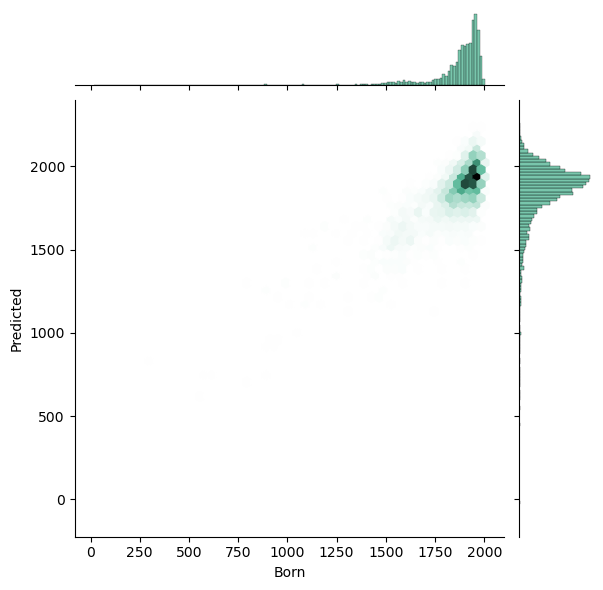

In [31]:
sns.jointplot(data=df, x='Born', y='Predicted', kind="hex", color="#4CB391")

Huh! it's a bit tough to see over such a long span, but it looks like most of the people are born in later years. Let's try to zoom in a bit for the people born after 1500. Modify the plot code above in the cell below to only plot our predictions for people born after 1500. What do you see?

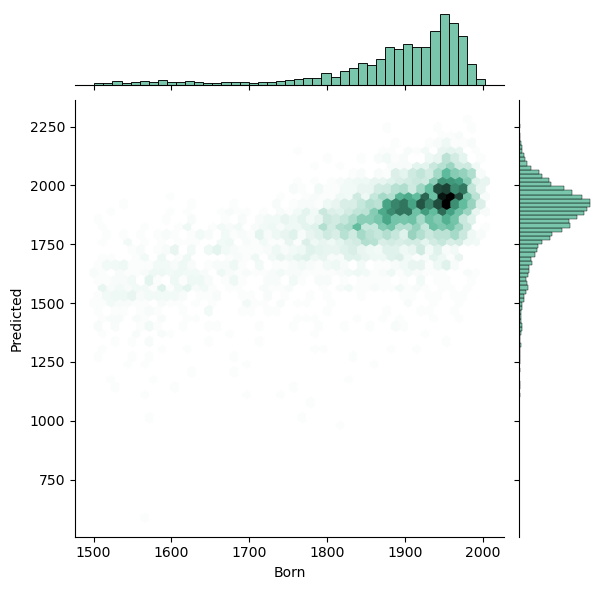

In [32]:
sns.jointplot(data=df[df['Born'] > 1500], x='Born', y='Predicted', kind="hex", color="#4CB391")

### Now let's plot the error distribution!

<AxesSubplot: xlabel='Error', ylabel='Density'>

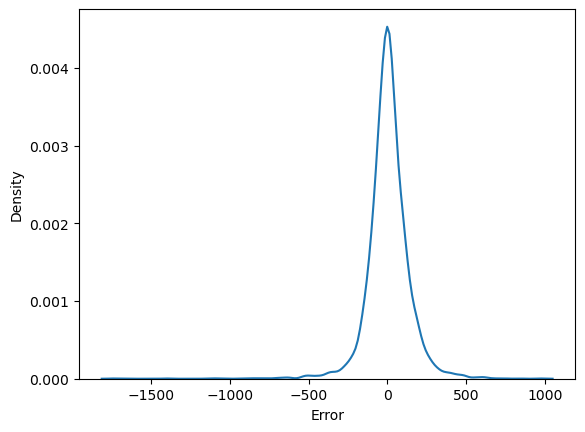

In [33]:
sns.kdeplot(df.Error)

Not a bad distribution, but are all the errors distributed equally? Let's make a `lineplot` that shows the  relationship between two variables. What do you see in the data? What kinds of mistakes is your model likely to make?

<AxesSubplot: xlabel='Born', ylabel='Error'>

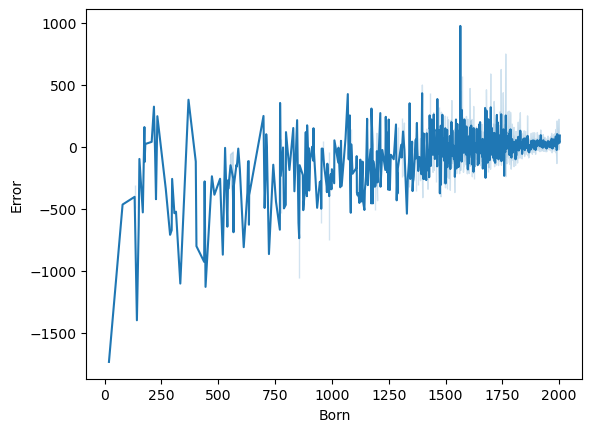

In [34]:
sns.lineplot(data=df, x='Born', y='Error')